# Autoenconder Version

Autoencoder is a kind of neural network that is trained to copy its input to output
One autoencoder will learn to compress the information while minimizing construction error. Usually can be used for example to detect anomalies or image denoising. However, VAE is like a autoencoder, only instead of converting the input to a map, VAE will transform the input into parameters of the probability as Mean or variance of gaussian

#### Imports

In [7]:
# imports
import os
import pandas as pd
import random
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, Model, metrics
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout,Activation, LeakyReLU, BatchNormalization, Conv2DTranspose, Reshape, Input, InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
import pathlib
import tensorflow_addons as tfa
import sys
from PIL import Image


#### Default Values

In [8]:
# DATASET VALUES
BATCH_SIZE = 128
DATASET_DIRECTORY = "./dataset/cropped/"
IMAGE_SIZE = 64
REMOVED = True

# MODEL VALUES
NOISE_DIM = 128
KERNEL_SIZE = 3
STRIDES = 2

# TRAIN VALUES
EPOCHS = 10

#### Loading dataset

In [9]:
# This dataset has a small problem, there are some corrupted images with a filesize of 0 bytes, so we need to remove them...
if not REMOVED:
    for root, dirs, files in os.walk("dataset"):
      for file in files:
        path = os.path.join(root, file)
        if os.stat(path).st_size == 0:
          print("Removing file:", path)
          os.remove(path)

In [10]:
# Loading dataset
# Every image will be converted to 64x64, making sure they are all the same size
dataset = tf.keras.preprocessing.image_dataset_from_directory(DATASET_DIRECTORY, label_mode = None, image_size = (IMAGE_SIZE,IMAGE_SIZE) , batch_size=BATCH_SIZE)

# Normalize the dataset
dataset = dataset.map(lambda x: (x /255))

Found 63569 files belonging to 1 classes.


### Autoencoder model
The Autoencoder will consist of 2 layers: an encoder and decoder.
The encoder will transform the images into latent space and the decoder will reconstruct the original image from that space.

#### Encoder
A VAE will have an Encoder that will try to compressing images into a latent space, which benefits primarily for images generating, this model will have a Dense layer that receives the image as input.

In [11]:

class Sampling(layers.Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [12]:
encoder_inputs = keras.Input(shape=(64, 64, 3))

x = layers.Conv2D(32, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name = "conv_1")(encoder_inputs)
x = BatchNormalization()(x)

x = layers.Conv2D(64, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name = "conv_2")(x)
x = BatchNormalization()(x)

x = layers.Conv2D(128, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name = "conv_3")(x)
x = BatchNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu", name ="dense_1")(x)
x = BatchNormalization()(x)


z_mean = layers.Dense(512, name="z_mean")(x)
z_log_var = layers.Dense(512, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

A
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 16, 16, 64)   18496       batch_normalization[0][0]        
__________________________________________________________________________________________

#### Decoder
Decoder will be responsible to reconstruct the original image.

In [13]:
latent_inputs = keras.Input(shape=(512,))
x = layers.Dense(8 * 8 * 64, activation="relu")(latent_inputs)
x = BatchNormalization()(x)
x = layers.Reshape((8, 8, 64), name = "reshape_1")(x)


x = layers.Conv2DTranspose(128, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name ="transp_1")(x)

x = layers.Conv2DTranspose(64, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name = "transp_2")(x)

x = layers.Conv2DTranspose(32, kernel_size=KERNEL_SIZE, activation="relu", strides=STRIDES, padding="same", name = "transp_3")(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              2101248   
_________________________________________________________________
batch_normalization_4 (Batch (None, 4096)              16384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
transp_1 (Conv2DTranspose)   (None, 16, 16, 128)       73856     
_________________________________________________________________
transp_2 (Conv2DTranspose)   (None, 32, 32, 64)        73792     
_________________________________________________________________
transp_3 (Conv2DTranspose)   (None, 64, 64, 32)        1846

#### Creating VAE Class

In [14]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            
            # Reconstruction 
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)))
            
            # KL divergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
        
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

#### Training Model

In [15]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam')
vae.fit(dataset, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/30
497/497 [==============================] - 36s 60ms/step - loss: 2500.3738 - reconstruction_loss: 2377.9600 - kl_loss: 27.3861
Epoch 2/30
497/497 [==============================] - 29s 59ms/step - loss: 2308.1800 - reconstruction_loss: 2259.3867 - kl_loss: 41.9593
Epoch 3/30
497/497 [==============================] - 29s 59ms/step - loss: 2285.9894 - reconstruction_loss: 2235.2422 - kl_loss: 44.6200
Epoch 4/30
497/497 [==============================] - 30s 59ms/step - loss: 2266.0030 - reconstruction_loss: 2216.7195 - kl_loss: 44.8549
Epoch 5/30
497/497 [==============================] - 30s 59ms/step - loss: 2250.9429 - reconstruction_loss: 2202.3469 - kl_loss: 44.8596
Epoch 6/30
497/497 [==============================] - 30s 59ms/step - loss: 2239.8183 - reconstruction_loss: 2191.9600 - kl_loss: 45.2786
Epoch 7/30
497/497 [==============================] - 30s 59ms/step - loss: 2231.3700 - reconstruction_loss: 2182.1816 - kl_loss: 46.7738
Epoch 8/30
497/497 [==============

#### Results
GAN - it is very easy for the discriminator to learn to detect blurry edges, so the generator has to produce sharp images to improve the loss function. But, with VAE the loss function usually penalizes putting a feature in the wrong spot worse than it penalizes blurring out or entirely skipping over that feature.

In [16]:
pred= decoder.predict(np.random.randn(100, 512))

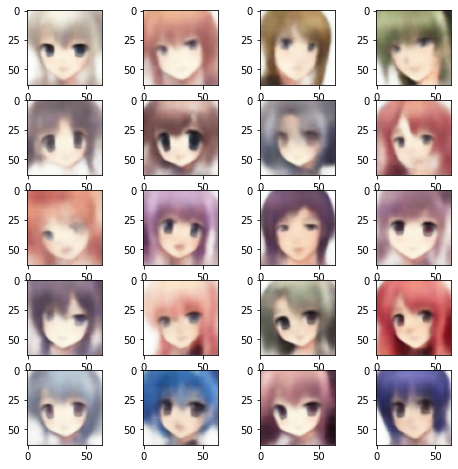

In [17]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(pred[i])
plt.show()